### Load Packages and Data

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


# import seaborn as sns
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import cross_val_score, KFold


# the below extension properly formats a cell after it is run
%load_ext nb_black

# Set the maximum number of rows to 200
pd.set_option("display.max_rows", 200)


# Set the maximum number of columns to 200
pd.set_option("display.max_columns", 200)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [82]:
# Load Data
housing = pd.read_csv("../data/housing_corr.csv")

<IPython.core.display.Javascript object>

In [83]:
housing.shape

(2558, 65)

<IPython.core.display.Javascript object>

In [84]:
# Dropping columns not needed
housing.drop(
    ["PID", "Neighborhood_st"], axis=1, inplace=True,
)

<IPython.core.display.Javascript object>

### Ordinal encoding data

In [85]:
# get a list of categorical features (i.e., object type columns)
cat_features = list(housing.select_dtypes(include=["object"]).columns)

# create an instance of the OrdinalEncoder class
ordinal_encoder = OrdinalEncoder()


# fit the ordinal encoder to the categorical features
ordinal_encoder.fit(housing[cat_features])

# transform the categorical features into encoded numerical values
housing[cat_features] = ordinal_encoder.transform(housing[cat_features])

<IPython.core.display.Javascript object>

## Train Test Split

In [86]:
X = housing.loc[:, housing.columns != "SalePrice"]
y = housing.loc[:, "SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2,
)

<IPython.core.display.Javascript object>

In [87]:
print(X_train.shape)
print(X_test.shape)

(2046, 62)
(512, 62)


<IPython.core.display.Javascript object>

### Model Scoring Function

In [88]:


def r2mae_scores(model, X, y, cv=5):
    """
    Calculate R^2 and Mean Absolute Error (MAE) scores for the given model using cross-validation.
    
    Args:
        model: A scikit-learn model
        X: The feature matrix (numpy array or pandas DataFrame)
        y: The target variable (numpy array or pandas Series)
        cv: Number of folds for cross-validation (default: 5)

    Returns:
        avg_r2_score: The average R^2 score across the cross-validation folds
        avg_MAE_score: The average MAE score across the cross-validation folds
    """

    # Using R^2 as the scoring metric
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1)

    # Using Mean Absolute Error as the scoring metric
    mae_scores = cross_val_score(
        model, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1
    )

    # Convert the MAE scores back to positive
    mae_scores = -1 * mae_scores

    avg_r2_score = np.mean(r2_scores)
    avg_MAE_score = np.mean(mae_scores)

    return avg_r2_score, avg_MAE_score


def print_scores(avg_r2_score, avg_MAE_score):
    """
    Print the average R^2 and MAE scores.

    Args:
        avg_r2_score: The average R^2 score
        avg_MAE_score: The average MAE score
    """
    print("-" * 50)
    print("5-fold Cross Validation Scoring")
    print("Average R^2 score:", avg_r2_score)
    print("Average MAE score:", avg_MAE_score)
    print("-" * 50)




<IPython.core.display.Javascript object>

### Random Tree Regression

In [89]:
model = ensemble.RandomForestRegressor(random_state=0)
avg_r2_score, avg_MAE_score = r2mae_scores(model, X_train, y_train)
print_scores(avg_r2_score, avg_MAE_score)


--------------------------------------------------
5-fold Cross Validation Scoring
Average R^2 score: 0.8962459717714694
Average MAE score: 14961.556414693212
--------------------------------------------------


<IPython.core.display.Javascript object>

### Feature Selection and Optimizing Number of Features

In [90]:

# 
# from sklearn.model_selection import cross_val_score

np.random.seed(42)

def feature_importance(model, X, y):
    model.fit(X, y)
    return sorted(zip(X.columns, model.feature_importances_), key=lambda t: t[1], reverse=True)

def r2_score_by_feature_count(model, X_train, y_train, X_test, y_test):
    sorted_features = feature_importance(model, X_train, y_train)
    selected_columns = [col for col, _ in sorted_features]
    
    scores = []
    for i in range(len(selected_columns)):
        X_train_subset = X_train[selected_columns[: i + 1]]
        X_test_subset = X_test[selected_columns[: i + 1]]

        model.fit(X_train_subset, y_train)
        score = cross_val_score(model, X_test_subset, y_test, cv=5, scoring="r2", n_jobs=-1)
        scores.append((i, np.mean(score)))

    return scores

def plot_scores(scores):
    x_values = [t[0] for t in scores]
    y_values = [t[1] for t in scores]

    plt.plot(x_values, y_values)
    plt.axvline(x=29, color="red", linestyle="--", alpha=0.4)

    plt.xlabel("# of Features")
    plt.ylabel("R^2 Performance")
    plt.title("Feature Selection")

    plt.show()




<IPython.core.display.Javascript object>

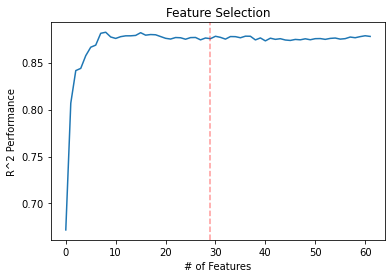

<IPython.core.display.Javascript object>

In [91]:

model = RandomForestRegressor(random_state=0)
scores = r2_score_by_feature_count(model, X_train, y_train, X_test, y_test)
plot_scores(scores)


In [92]:
def plot_feature_importance(model, X_train, n_features=35):
    sorted_importance = sorted(
        zip(X_train.columns, model.feature_importances_),
        key=lambda t: t[1],
        reverse=True,
    )

    # Get data for the plot (n_features based on your preference)
    a, b = zip(*sorted_importance[:n_features])
    df = pd.DataFrame({"feature_name": a, "importance_score": b})

    # Plot
    plt.figure(figsize=(20, 10))
    df.plot.bar(x="feature_name", y="importance_score", legend=None)
    plt.title("Feature Importance")
    plt.show()



<IPython.core.display.Javascript object>

<Figure size 1440x720 with 0 Axes>

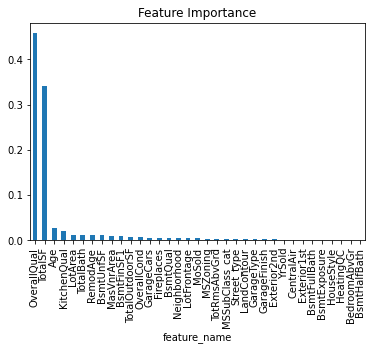

<IPython.core.display.Javascript object>

In [93]:
random_forest_model = RandomForestRegressor(random_state=0)
random_forest_model.fit(X_train, y_train)
plot_feature_importance(random_forest_model, X_train, n_features=35)


## Comparing Models of Optimal Features Vs All Features

In [94]:
def compare_models(model, X_train, y_train, X_test, y_test, optimal_features_count):
    # All features
    model.fit(X_train, y_train)
    all_features_score = model.score(X_test, y_test)

    # Optimal features
    sorted_features = feature_importance(model, X_train, y_train)
    selected_columns = [col for col, _ in sorted_features][:optimal_features_count]
    
    X_train_optimal = X_train[selected_columns]
    X_test_optimal = X_test[selected_columns]

    model.fit(X_train_optimal, y_train)
    optimal_features_score = model.score(X_test_optimal, y_test)

    return all_features_score, optimal_features_score




<IPython.core.display.Javascript object>

In [95]:
model = RandomForestRegressor(random_state=0)
optimal_features_count = 29  # This from the plot_scores function
all_features_score, optimal_features_score = compare_models(
    model, X_train, y_train, X_test, y_test, optimal_features_count
)

print("R^2 score using all features: ", all_features_score)
print("R^2 score using optimal features: ", optimal_features_score)

R^2 score using all features:  0.9101409579414029
R^2 score using optimal features:  0.9098519833873219


<IPython.core.display.Javascript object>

The scores show that using all features is best and this is also what the plot shows

## Checking for Overfitting by Looking at the Train and Test Errors

In [96]:


def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Make predictions on the train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate the mean squared error for the train and test sets
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Calculate the R^2 for the train and test sets
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print("The training error (MSE) is: %.5f" % mse_train)
    print("The test     error (MSE) is: %.5f" % mse_test)
    print("The training R^2 is: %.5f" % r2_train)
    print("The test     R^2 is: %.5f" % r2_test)





<IPython.core.display.Javascript object>

In [97]:
random_forest_model = RandomForestRegressor(random_state=0)
evaluate_model(random_forest_model, X_train, y_train, X_test, y_test)

The training error (MSE) is: 84864780.89919
The test     error (MSE) is: 532073046.11335
The training R^2 is: 0.98464
The test     R^2 is: 0.91014


<IPython.core.display.Javascript object>

Model is overfitting

# Tuning the Hyper Parameters

In [98]:

def find_best_params(X_train, y_train):
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt']
    }

    # Create a RandomForestRegressor object
    rf = RandomForestRegressor(random_state=0)

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    return grid_search.best_params_

best_params = find_best_params(X_train, y_train)
print("Best parameters found by GridSearchCV:")
print(best_params)

# Create and fit a RandomForestRegressor model with the best parameters found
best_rf = RandomForestRegressor(**best_params, random_state=0)
evaluate_model(best_rf, X_train, y_train, X_test, y_test)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters found by GridSearchCV:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
The training error (MSE) is: 85775615.50893
The test     error (MSE) is: 567413664.76211
The training R^2 is: 0.98448
The test     R^2 is: 0.90417


<IPython.core.display.Javascript object>

# Using Shap to look at the features that contributed the most to the SalePrice

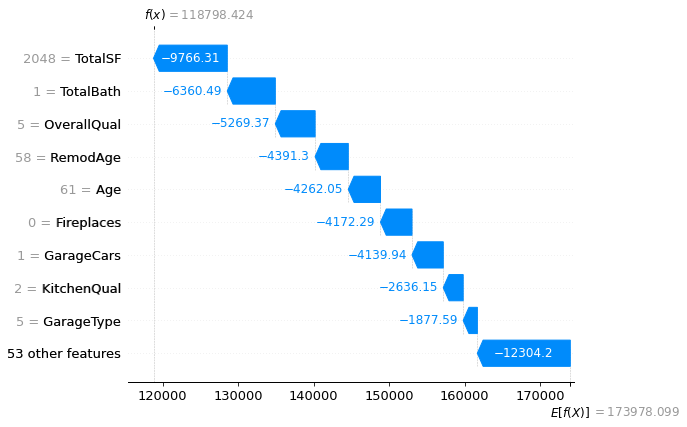

<IPython.core.display.Javascript object>

In [99]:


# Create a SHAP explainer for the RandomForest model
explainer = shap.Explainer(best_rf, X_train)

# Calculate SHAP values for the first instance in the dataset
instance_index = 0
shap_values_instance = explainer(X_train.iloc[instance_index:instance_index + 1, :])

# Plot the SHAP values as a waterfall plot for the instance
shap.plots.waterfall(shap_values_instance[0])



## Looking at the TotalBath feature affects SalePrice

In [100]:
# Funtion to look at the average value of SalePrice for various values in TotalBath
def predict_total_bath_effect(model, X, total_bath_values):
    original_total_bath = X['TotalBath'].copy()
    predictions = []

    for val in total_bath_values:
        X['TotalBath'] = val
        pred = model.predict(X)
        predictions.append(pred.mean())

    X['TotalBath'] = original_total_bath
    return predictions


<IPython.core.display.Javascript object>

In [101]:
total_bath_values = [1, 1.5, 2, 2.5, 3.0, 3.5, 4.0]
predictions = predict_total_bath_effect(best_rf, X_train, total_bath_values)

for val, pred in zip(total_bath_values, predictions):
    print(f"Average prediction for TotalBath = {val}: {pred}")

Average prediction for TotalBath = 1: 171082.4494735147
Average prediction for TotalBath = 1.5: 173267.93379741104
Average prediction for TotalBath = 2: 174104.68749574412
Average prediction for TotalBath = 2.5: 180192.75547220136
Average prediction for TotalBath = 3.0: 181719.01118371627
Average prediction for TotalBath = 3.5: 183638.9909662303
Average prediction for TotalBath = 4.0: 184394.2490438705


<IPython.core.display.Javascript object>

## SHAP for total bathrooms

100%|===================| 2036/2046 [02:11<00:00]        

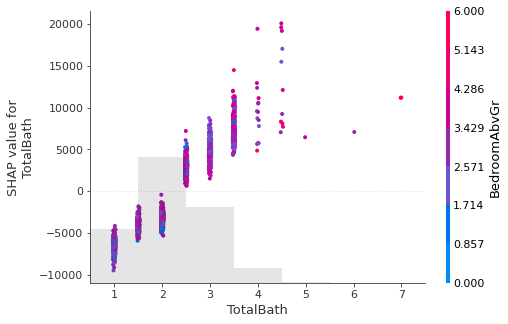

<IPython.core.display.Javascript object>

In [102]:
# Looking at the interaction of total bathrooms and total bedrooms

# Create a SHAP explainer for the RandomForest model
explainer = shap.Explainer(best_rf, X_train)

# Calculate SHAP values for the entire dataset
shap_values = explainer(X_train)

# Plot the interaction between TotalBath and BedroomAbvGr
shap.plots.scatter(shap_values[:, "TotalBath"], color=shap_values[:, "BedroomAbvGr"])

plt.show()

It looks like there are a few plots where the value in TotalBath contributes to more than $10,0000
of the saleprice

In [103]:
# Finding indices of observations with a SHAP value for TotalBath greater than 10000
high_shap_indices = np.where(shap_values[:, X_train.columns.get_loc("TotalBath")].values > 10000)[0]

print("Indices of observations with high SHAP values for TotalBath:", high_shap_indices)


Indices of observations with high SHAP values for TotalBath: [  67   84   85  134  155  168  190  300  340  420  560  572  576  614
  663  670  702  710  786  793  931  995  999 1144 1192 1281 1288 1409
 1450 1783 1804 1900 1913 2007]


<IPython.core.display.Javascript object>

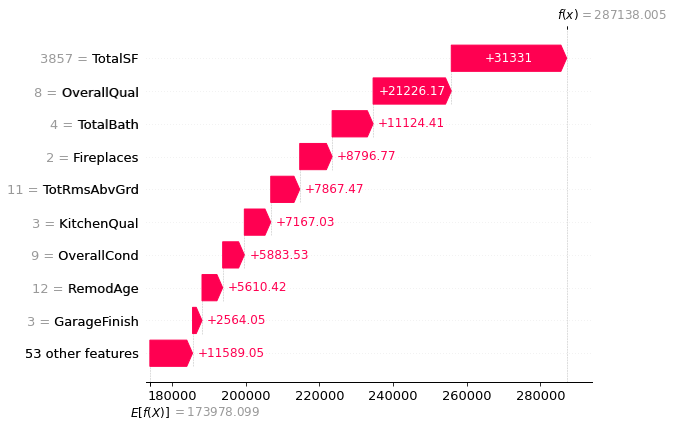

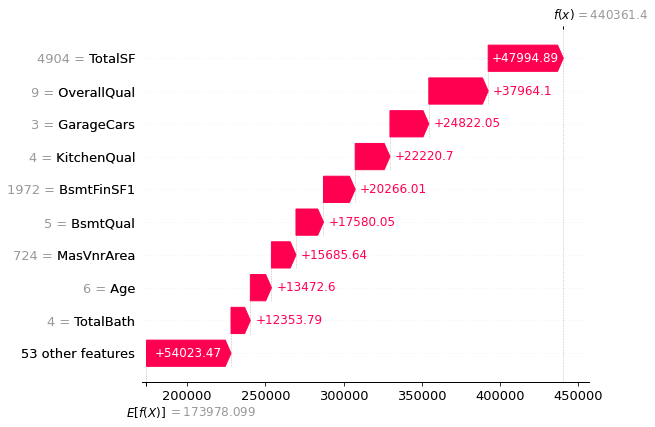

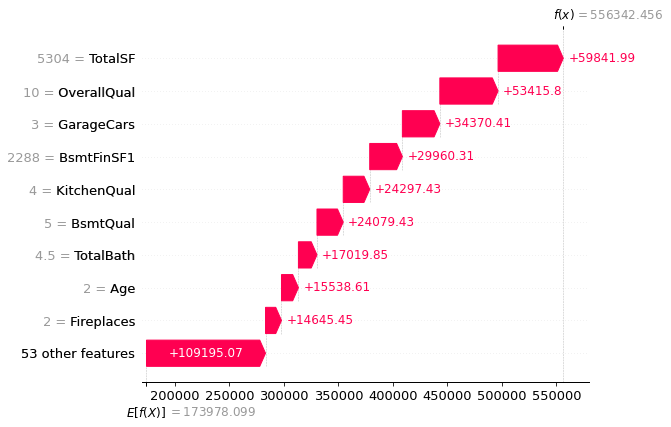

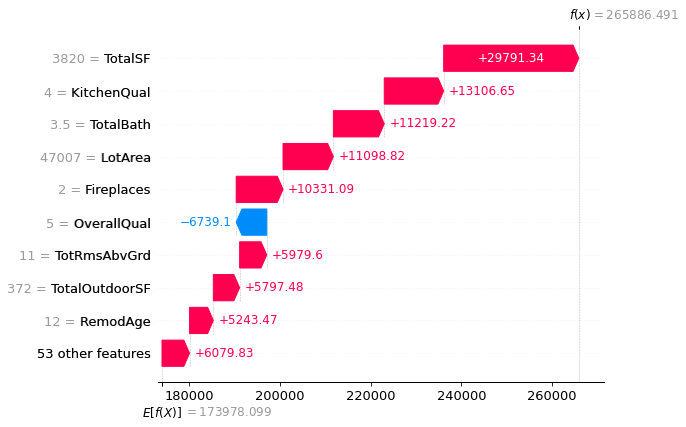

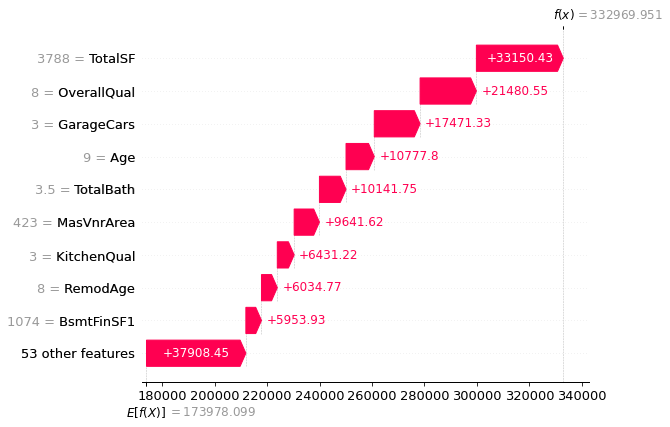

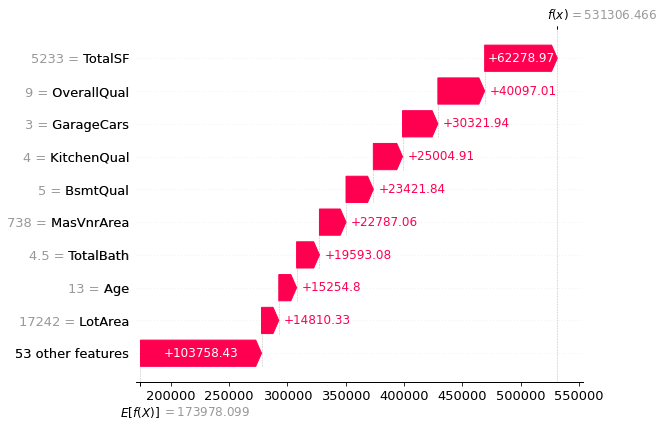

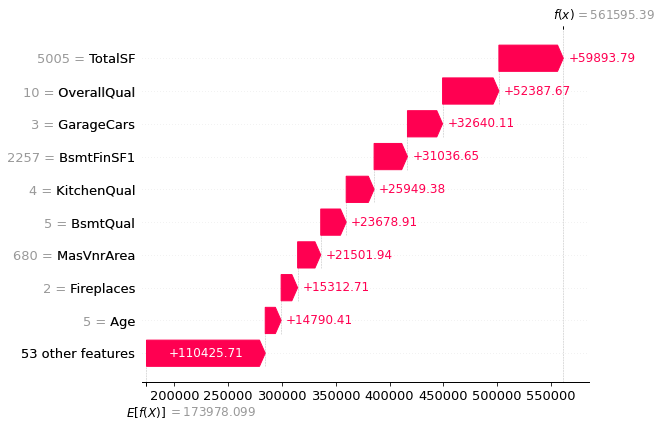

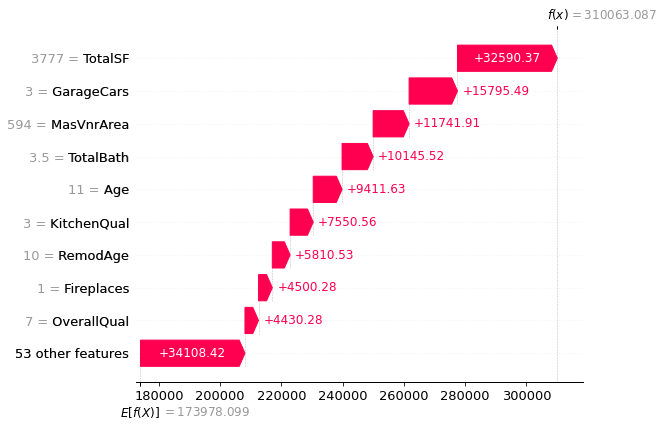

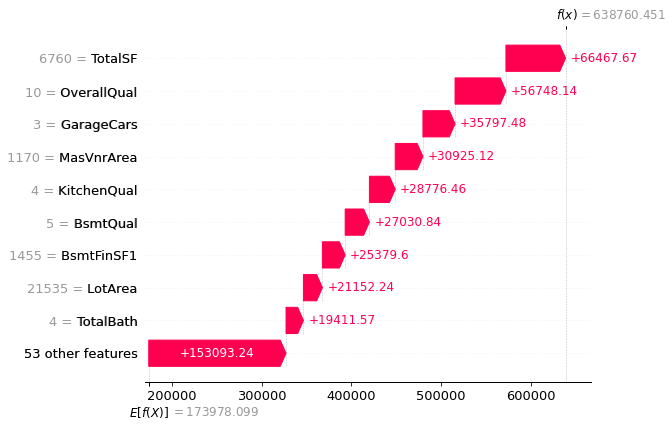

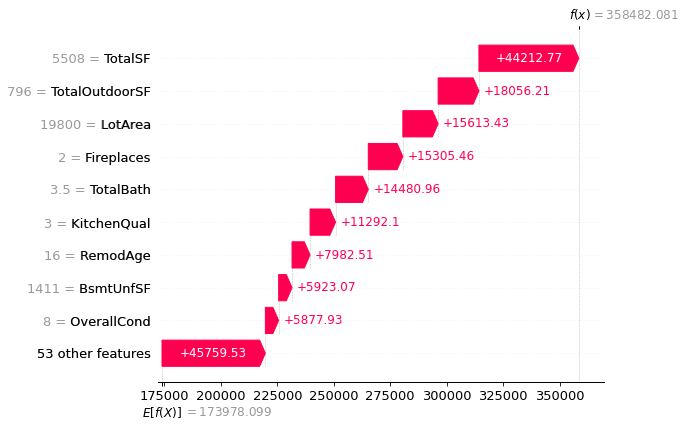

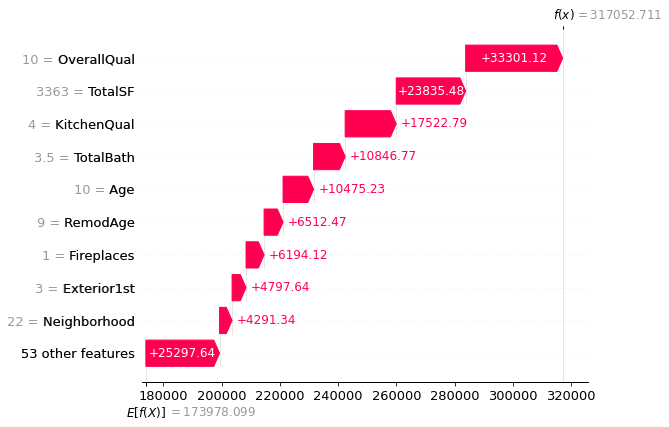

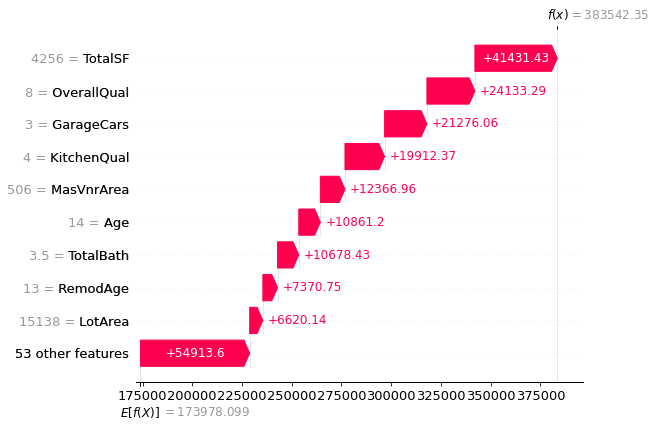

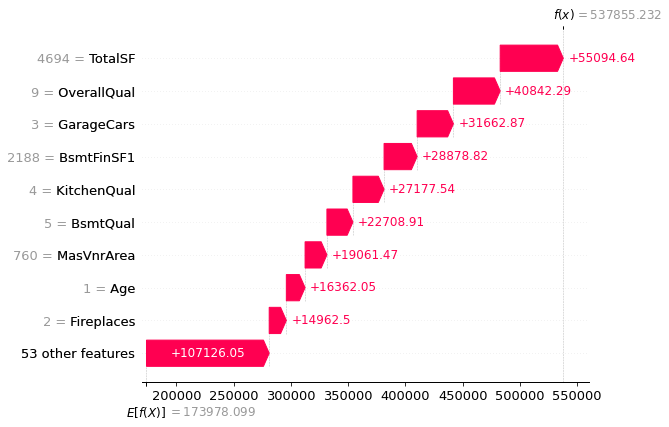

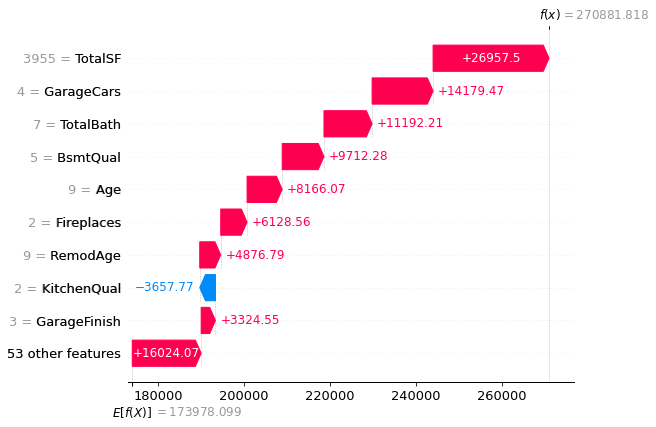

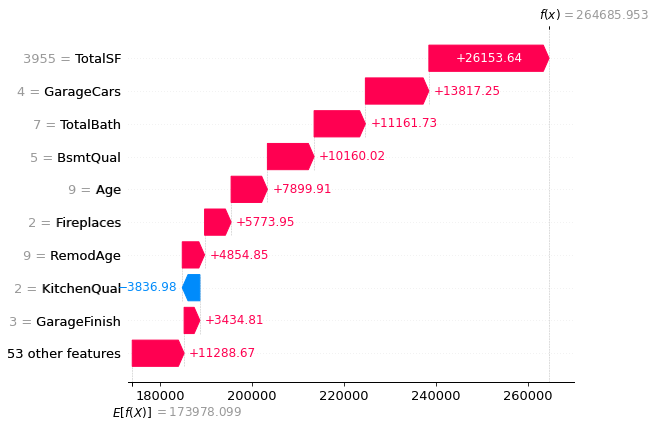

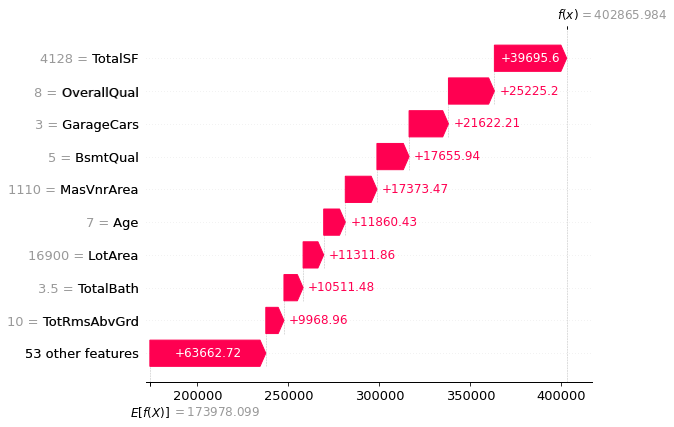

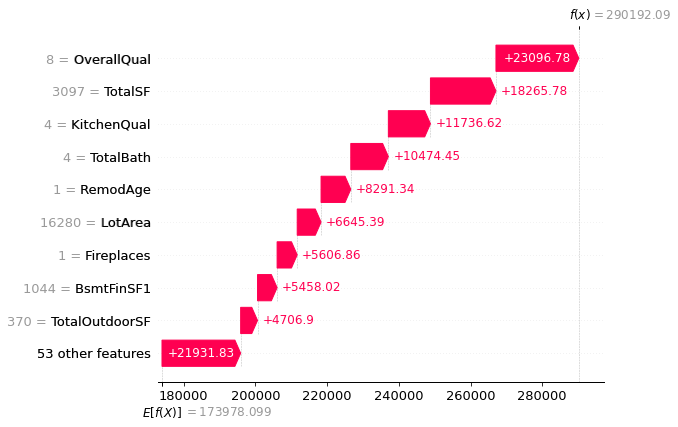

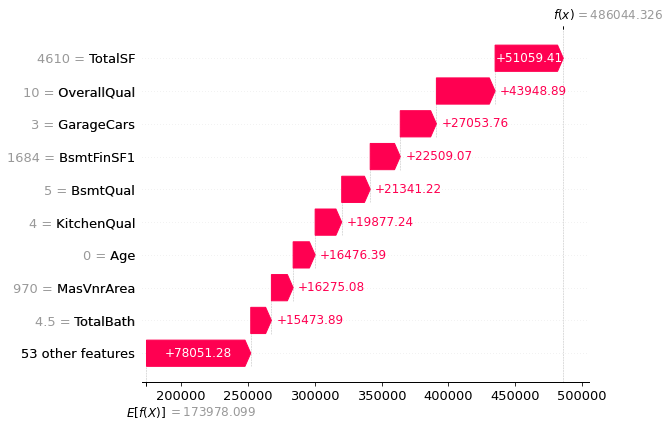

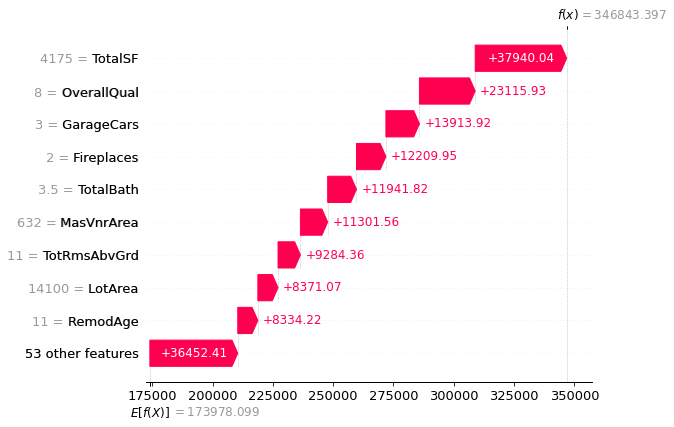

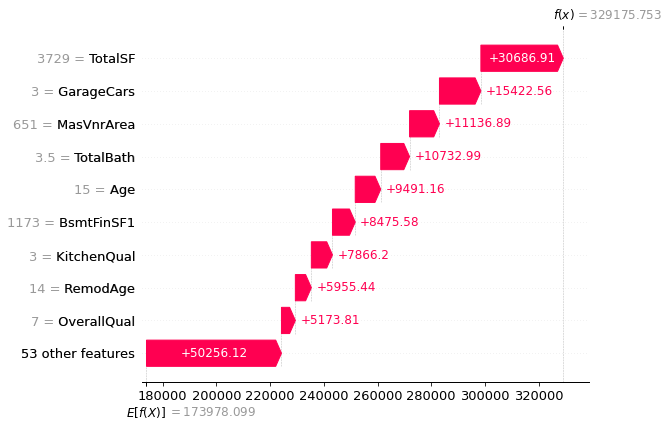

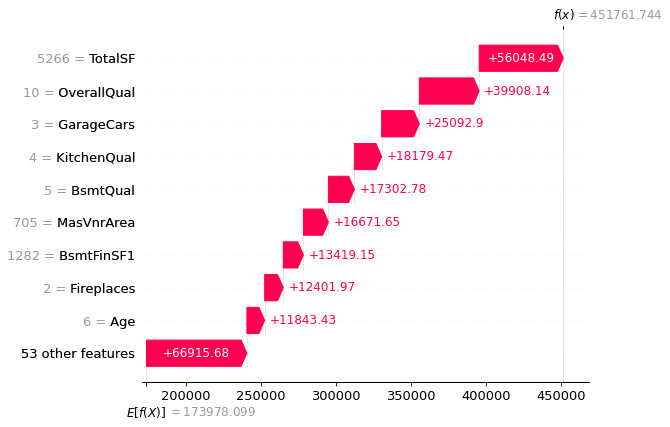

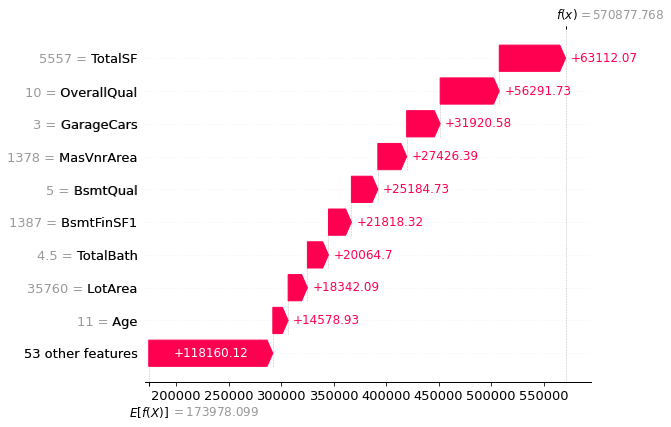

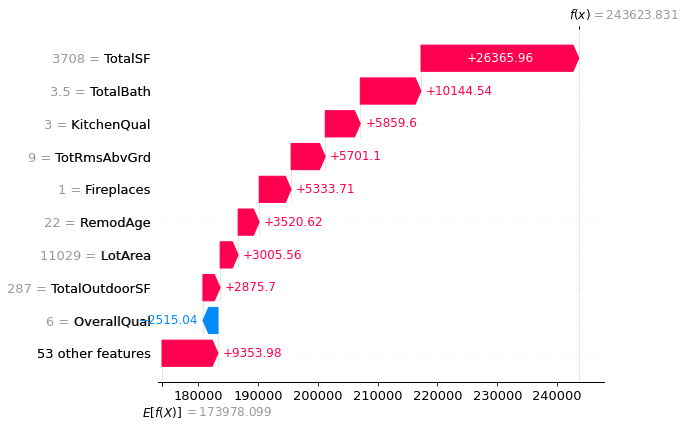

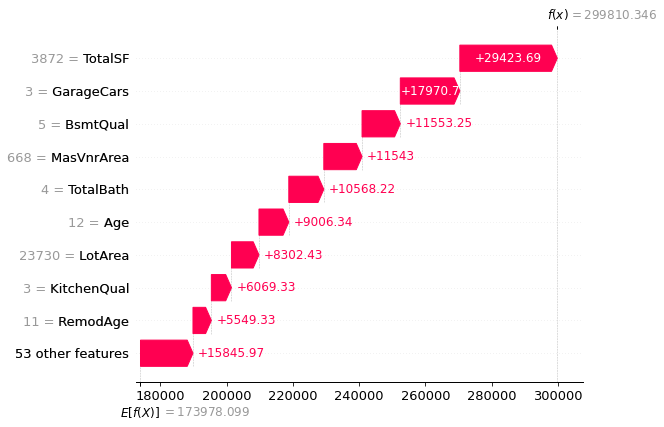

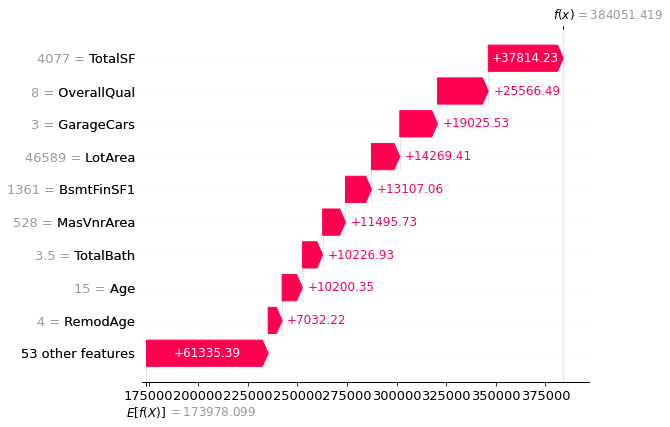

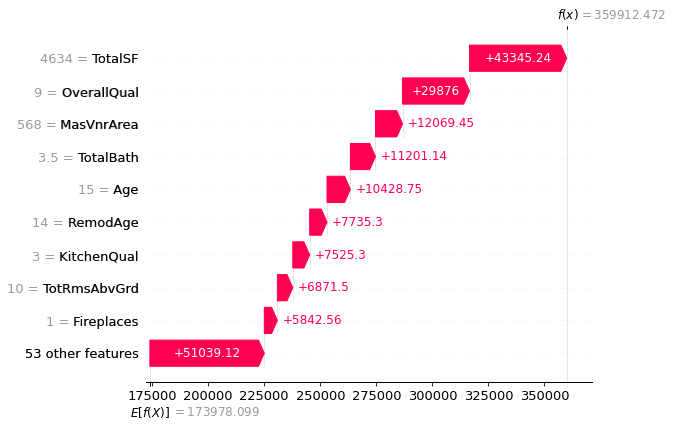

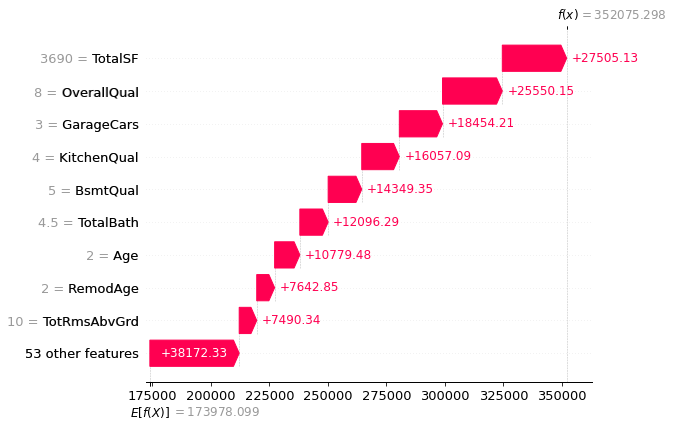

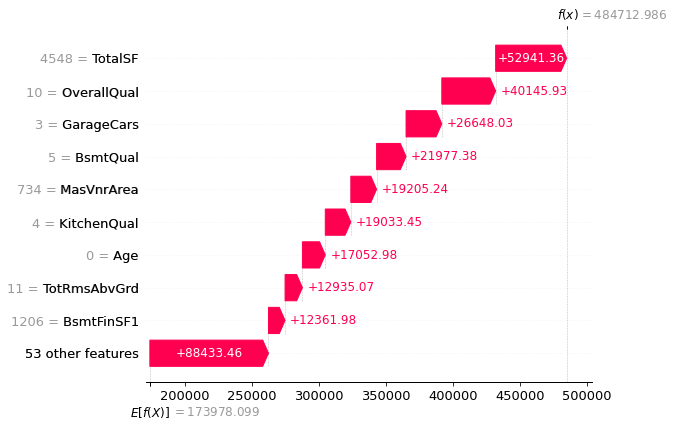

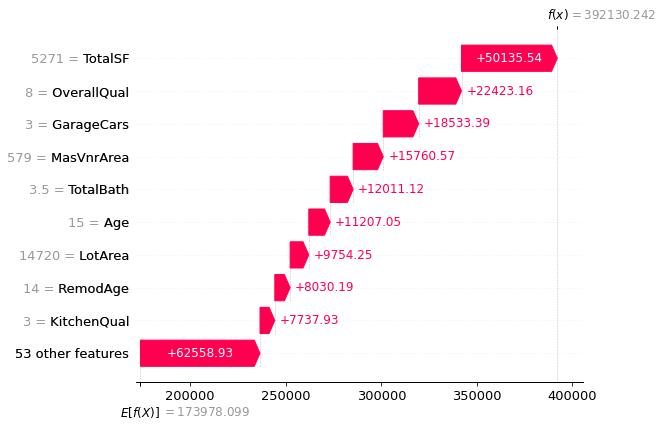

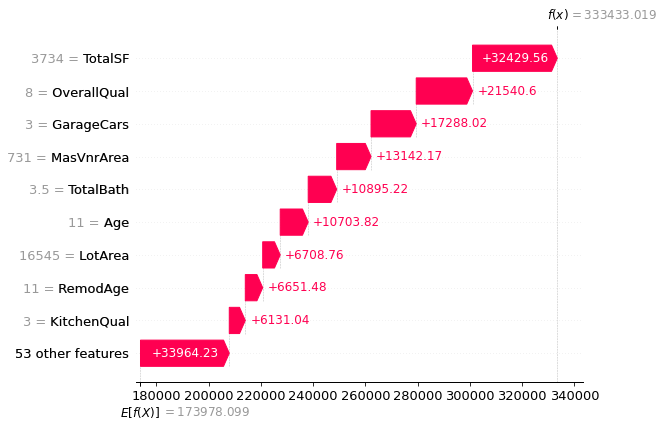

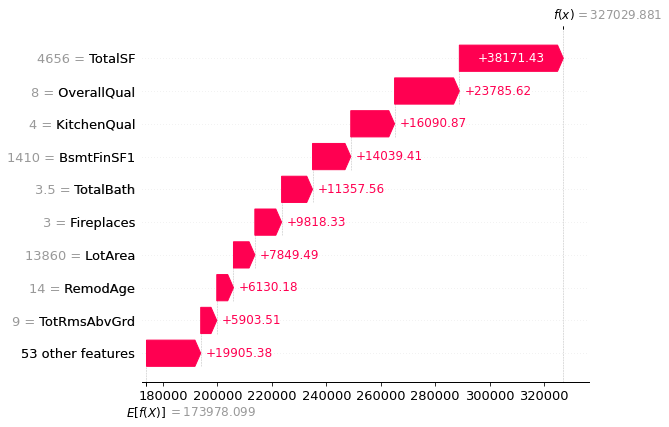

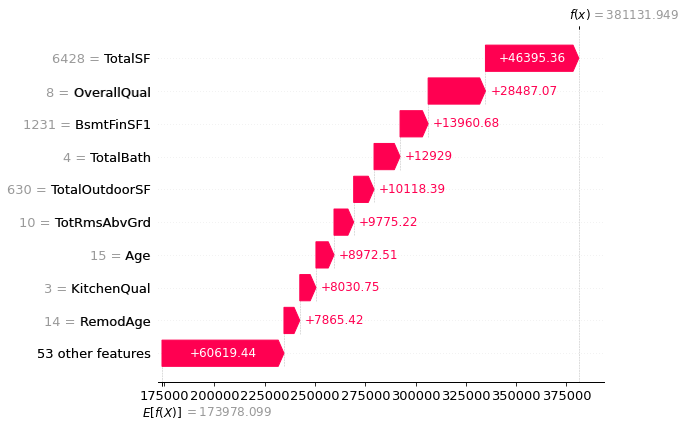

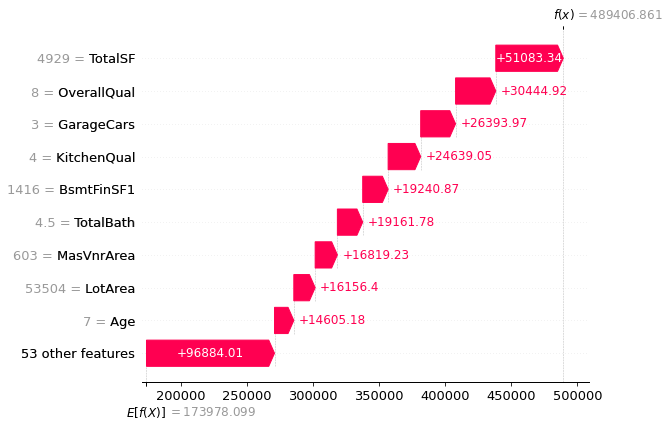

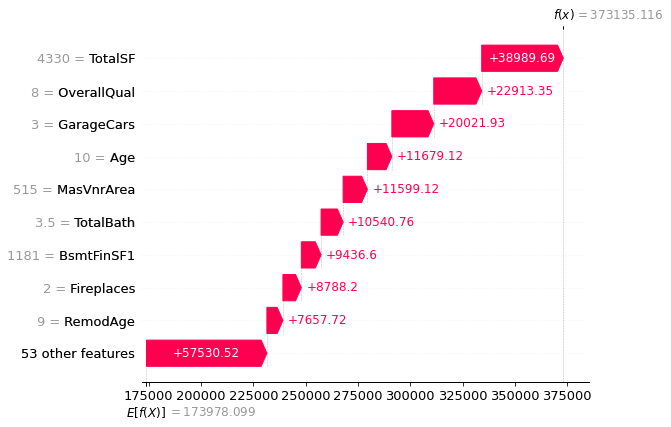

<IPython.core.display.Javascript object>

In [104]:
# Plot the SHAP values as a waterfall plot for each high-value observation
for index in high_shap_indices:
    shap_values_instance = explainer(X_train.iloc[index:index + 1, :])
    shap.plots.waterfall(shap_values_instance[0])
    plt.show()


 96%|=================== | 1974/2046 [02:11<00:04]       

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END max_depth=None, max_f

 98%|===================| 2008/2046 [02:13<00:02]        

CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=

 99%|===================| 2024/2046 [02:14<00:01]       

otal time=   3.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.7s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.5s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   2.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=30

100%|===================| 2041/2046 [02:15<00:00]       

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, 

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END max_depth=None,

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_

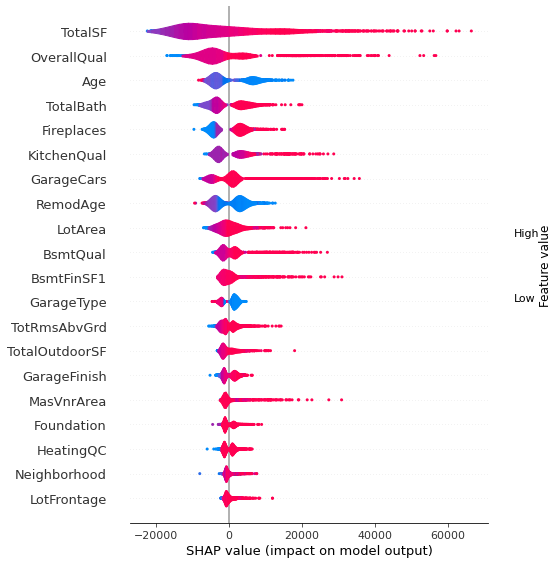

<IPython.core.display.Javascript object>

In [105]:
# Calculate SHAP values for the entire dataset
shap_values = explainer(X_train)

# Get the base value (expected value) from the explainer
base_value = shap_values.base_values

# Set the expected_value attribute for the SHAP values
shap_values.expected_value = base_value

# Plot the SHAP violin plot for all features
shap.plots.violin(shap_values)



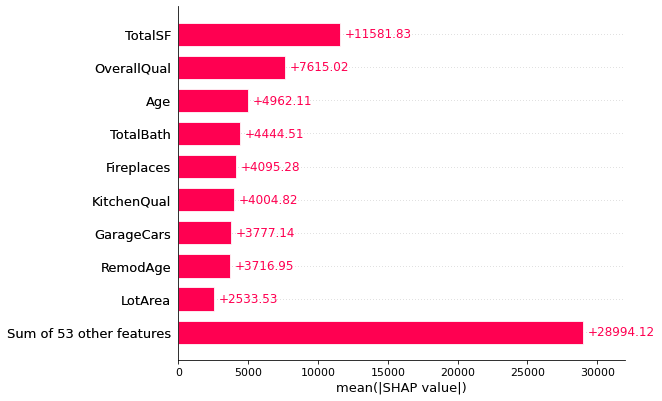

<IPython.core.display.Javascript object>

In [106]:
shap.plots.bar(shap_values)

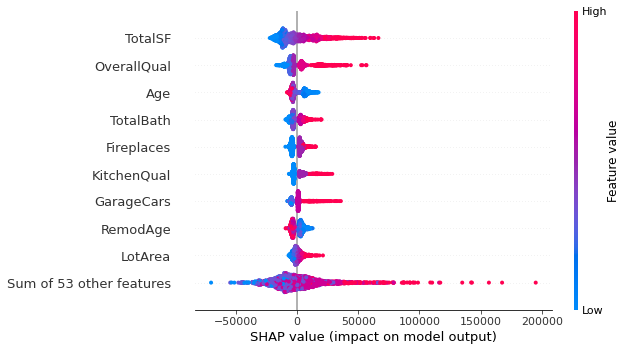

<IPython.core.display.Javascript object>

In [107]:
shap.plots.beeswarm(shap_values)